In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Download stock data
stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')

# Extract closing prices
close_prices = stock_data['Close']
values = close_prices.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

[*********************100%***********************]  1 of 1 completed


In [3]:
# Prepare training data
training_data_len = math.ceil(len(values) * 0.8)
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [4]:
# Build and train the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
1098/1098 [==============================] - 24s 19ms/step - loss: 6.9876e-04
Epoch 2/3
1098/1098 [==============================] - 21s 19ms/step - loss: 5.0067e-04
Epoch 3/3
1098/1098 [==============================] - 20s 19ms/step - loss: 2.5715e-04


In [6]:
# Prepare test data for predictions
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [7]:
# Generate predictions for the next 30 days
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

10/10 [==============================] - 1s 13ms/step


In [9]:
# Generate predictions for the next 30 days
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Reshape predictions array
predictions = predictions[-30:]  # Select the last 30 predictions
predictions = predictions.reshape(-1)

# Create a DataFrame with predicted prices
dates = pd.date_range(start=stock_data.index[training_data_len+60], periods=30, freq='D')
predicted_prices = pd.DataFrame(predictions, index=dates, columns=['Predicted Price'])

# Display the DataFrame
print(predicted_prices)

10/10 [==============================] - 0s 12ms/step
            Predicted Price
2020-11-03       153.438156
2020-11-04       152.252441
2020-11-05       152.302750
2020-11-06       153.259888
2020-11-07       153.966187
2020-11-08       153.780685
2020-11-09       153.146317
2020-11-10       153.168869
2020-11-11       155.329071
2020-11-12       156.375076
2020-11-13       157.092300
2020-11-14       157.926926
2020-11-15       158.693207
2020-11-16       160.186417
2020-11-17       160.436081
2020-11-18       159.886841
2020-11-19       157.118668
2020-11-20       155.428421
2020-11-21       154.032364
2020-11-22       153.763306
2020-11-23       153.759949
2020-11-24       152.630951
2020-11-25       150.414490
2020-11-26       149.169174
2020-11-27       149.705368
2020-11-28       150.789551
2020-11-29       151.562027
2020-11-30       151.233887
2020-12-01       149.264587
2020-12-02       148.208771


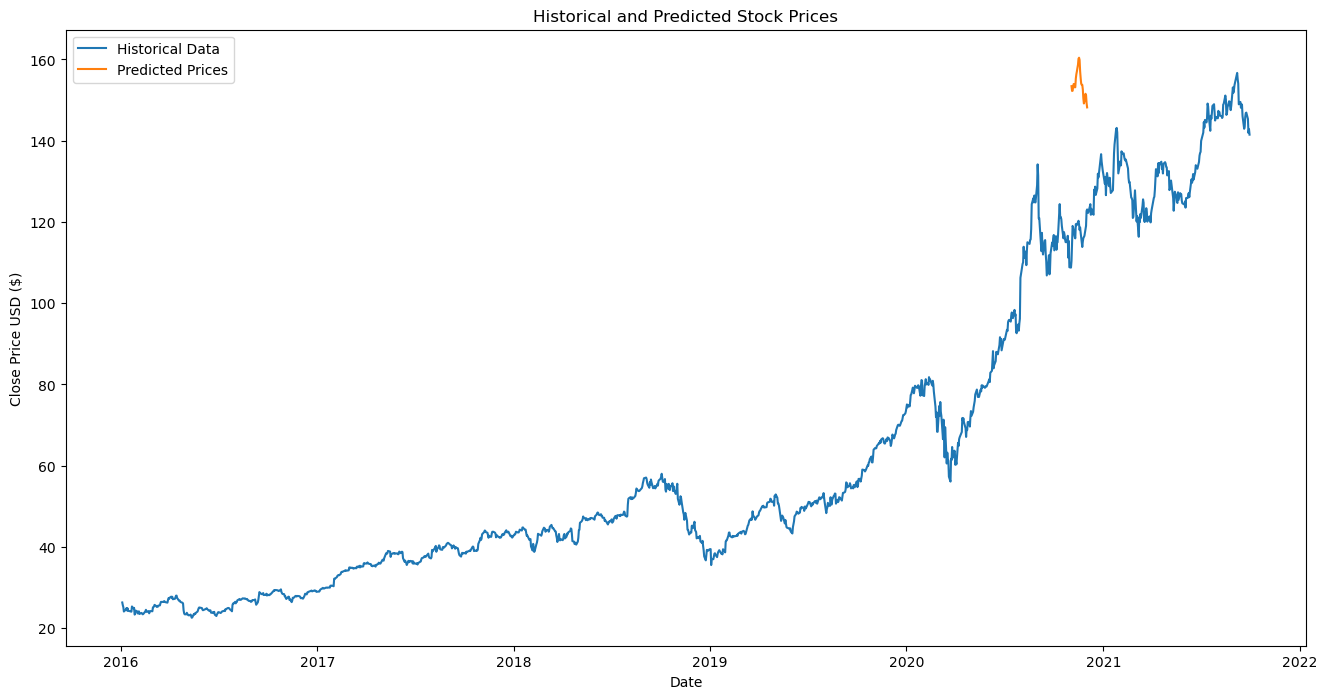

In [10]:
# Plotting historical data and predicted prices
plt.figure(figsize=(16,8))
plt.title('Historical and Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(stock_data['Close'], label='Historical Data')
plt.plot(predicted_prices, label='Predicted Prices')
plt.legend(loc='upper left')
plt.show()